# Load libraries

In [2]:
library(Seurat)
library(Signac)
library(Matrix)
library(readr)
library(ggplot2)
library(data.table)
library(GenomicRanges)
library(dplyr)
library(rtracklayer)

# Step 1: Load sparse matrix and convert to full matrix

Use the dataset: "PBMCs 3k cells from a healthy donor"
* Use the material provided as part of the exam.

Matrix conversion
* Use the Matrix R package to convert the sparse matrix into a full matrix.
* Save the result as a data.table object.


In [131]:
data_path <- "Data/matrix/"

In [132]:
matrix <- readMM(file = paste0(data_path, "matrix.mtx.gz"))
features <- read_tsv(file = paste0(data_path, "features.tsv.gz"), 
         col_names = c("id", "name", "type", "chr", "start", "end"), show_col_types = F)
barcodes <- read_tsv(file = paste0(data_path, "barcodes.tsv.gz"), col_names = F, show_col_types = F) 

In [5]:
colnames(matrix) <- barcodes$X1
rownames(matrix) <- features$id
matrix <- as.matrix(matrix)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


In [6]:
dt <- as.data.table(matrix, row.names = rownames(matrix))
dt[, id := rownames(matrix)]
setcolorder(dt, c("id", setdiff(names(dt), "id")))

In [3]:
# Step 1 ___________________________________________________________________________
s1.make.dt <- function(
    data_path = "/sharedFolder/Data/matrix/"
) {
    # Load the sparse matrix
    matrix <- readMM(file = paste0(data_path, "matrix.mtx.gz"))
    features <- read_tsv(file = paste0(data_path, "features.tsv.gz"), 
                         col_names = c("id", "name", "type", "chr", "start", "end"), 
                         show_col_types = F)
    barcodes <- read_tsv(file = paste0(data_path, "barcodes.tsv.gz"), 
                         col_names = F, 
                         show_col_types = F) 

    # Assign names to colums and rows and transform the object "matrix" in a matrix
    colnames(matrix) <- barcodes$X1
    rownames(matrix) <- features$id
    matrix <- as.matrix(matrix)

    # Genearate a data.table, a id columns containg the ids of the various genes/peaks is added 
    dt <- as.data.table(matrix, row.names = rownames(matrix))
    dt[, id := rownames(matrix)]
    setcolorder(dt, c("id", setdiff(names(dt), "id"))) # id is put as the first column


    return(dt)
}

In [4]:
dt <- s1.make.dt(data_path = "/sharedFolder/Data/matrix/")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


# Step 2: Split gene expression and ATAC-seq data

From the data.table object, separate:
* Gene expression data (rows labelled with Ensembl gene IDs, e.g., ENSG00000243485)
* ATAC-seq peak data (rows labelled with genomic coordinates, e.g., chrN:NNNN-NNNN)


In [8]:
dt_genes <- dt[grepl("ENSG", dt$id)]
dt_atac <- rbind(dt[grepl("chr", dt$id)])

In [5]:
# Step 2 ___________________________________________________________________________
s2.subset.dt <- function(
    string,
    data
) {
    # Use grepl to create a logic that indicates which elemnent of the data.table to take
    sub <- data[grepl(string, data$id)]
    return(sub)
}

In [6]:
dt_genes <- s2.subset.dt(string = "ENSG", data = dt)
dt_atac <- s2.subset.dt(string = "chr", data = dt)

# Step 3: Summarize Data

For each dataset (expression and peaks), compute the column-wise sum to produce:
* A single vector of total expression per gene
* A single vector of total chromatin accessibility per peak region

In [20]:
genes_summary <- dt_genes[, rowSums(.SD), .SDcols = -"id"]
names(genes_summary) <- dt_genes$id
#genes_summary[1:5]

In [9]:
atac_summary <- dt_atac[, rowSums(.SD), .SDcols = -"id"]
names(atac_summary) <- dt_atac$id
#atac_summary[1:5]

In [7]:
# Step 3 ___________________________________________________________________________
s3.summarize.data <- function(
    data
) {
    summary <- data[, rowSums(.SD), .SDcols = -"id"]
    names(summary) <- data$id
    return(summary)
}

In [8]:
genes_summary <- s3.summarize.data(data = dt_genes)
atac_summary <- s3.summarize.data(data = dt_atac)

# Step 4: Create GenomicRanges

* Convert both the summarized gene expression and peak data into GenomicRanges objects.
* Add the summarized data as metadata to their respective GenomicRanges.

In [25]:
features_dt <- as.data.table(features)

In [26]:
features_genes <- features_dt[grepl("Gene", features_dt$type)]
features_atac <- features_dt[grepl("Peaks", features_dt$type) & grepl("chr", features_dt$chr)]

In [27]:
features_genes$chr[is.na(features_genes$chr)] <- "unknown"

In [13]:
gr_genes <- GRanges(
    seqnames = features_genes$chr,
    ranges = IRanges(
        start = features_genes$start,
        end = features_genes$end
    ),
    gene_id = features_genes$id,
    name = features_genes$name,
    sum = genes_summary
)
head(gr_genes)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |         gene_id        name       sum
         <Rle>     <IRanges>  <Rle> |     <character> <character> <numeric>
  [1]     chr1   29553-30267      * | ENSG00000243485 MIR1302-2HG         0
  [2]     chr1   36080-36081      * | ENSG00000237613     FAM138A         0
  [3]     chr1   65418-69055      * | ENSG00000186092       OR4F5         0
  [4]     chr1 120931-133723      * | ENSG00000238009  AL627309.1        16
  [5]     chr1   91104-91105      * | ENSG00000239945  AL627309.3         1
  [6]     chr1 140338-140339      * | ENSG00000239906  AL627309.2         0
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [14]:
gr_atac <- GRanges(
    seqnames = features_atac$chr,
    ranges = IRanges(
        start = features_atac$start,
        end = features_atac$end
    ),
    peack_id = features_atac$id,
    sum = atac_summary
)
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |           peack_id       sum
         <Rle>     <IRanges>  <Rle> |        <character> <numeric>
  [1]     chr1    9782-10672      * |    chr1:9782-10672        46
  [2]     chr1 180547-181446      * | chr1:180547-181446        83
  [3]     chr1 191121-191998      * | chr1:191121-191998        20
  [4]     chr1 267553-268447      * | chr1:267553-268447        74
  [5]     chr1 270906-271782      * | chr1:270906-271782        26
  [6]     chr1 273943-274789      * | chr1:273943-274789        25
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [9]:
# Step 4 ___________________________________________________________________________
s4.create.GenomicRanges <- function(
    type,
    path_f = "/sharedFolder/Data/matrix/features.tsv.gz"
) {
    features <- as.data.table(
        read_tsv(
            file = path_f, 
            col_names = c("id", "name", "type", "chr", "start", "end"), 
            show_col_types = F
        )
    )
    if (type %in% c("Genes", "genes")) {
        if (type != "Genes") {type = "Genes"}
        
        features <- features[grepl("Gene", features$type)]
        features$chr[is.na(features$chr)] <- "unknown"

        summary = genes_summary
    } else if (type %in% c("Peaks", "peaks", "ATAC", "Atac", "atac")) {
        if (type != "Peaks") {type = "Peaks"}
        
        features <- features[grepl("Peaks", features$type) & grepl("chr", features$chr)]
        features$chr[is.na(features$chr)] <- "unknown"

        summary = atac_summary
    } else {
        print("Error, invalid value for type: must be 'Gene' or 'Peaks'")
        return ("")
    }

    gr <- GRanges(
        seqnames = features$chr,
        ranges = IRanges(
            start = features$start,
            end = features$end
        )
    )

    if (type == "Genes") {
        gr$gene_sum = summary
        gr$gene_id <- features$id
        gr$gene_name <- features$name
    } else if (type == "Peaks") {
        gr$peak_sum = summary
        gr$peak_id <- features$id
    }

    return(gr)
}

In [10]:
gr_genes <- s4.create.GenomicRanges("genes")
gr_atac <- s4.create.GenomicRanges("atac")

In [11]:
head(gr_genes)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |  gene_sum         gene_id   gene_name
         <Rle>     <IRanges>  <Rle> | <numeric>     <character> <character>
  [1]     chr1   29553-30267      * |         0 ENSG00000243485 MIR1302-2HG
  [2]     chr1   36080-36081      * |         0 ENSG00000237613     FAM138A
  [3]     chr1   65418-69055      * |         0 ENSG00000186092       OR4F5
  [4]     chr1 120931-133723      * |        16 ENSG00000238009  AL627309.1
  [5]     chr1   91104-91105      * |         1 ENSG00000239945  AL627309.3
  [6]     chr1 140338-140339      * |         0 ENSG00000239906  AL627309.2
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [12]:
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |  peak_sum            peak_id
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [ ]:
gr_genes <- s4.create.GenomicRanges("genes")
head(gr_genes)

In [76]:
gr_atac <- s4.create.GenomicRanges("atac")
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |       sum            peak_id
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

# Step 5: Gene Annotation for ATACseq data

Using the annotation file Homo_sapiens.GRCh38.114.gtf.gz:
* Create a GenomicRanges object only for protein-coding genes and only for gene features.
* Remap the ATAC-seq GenomicRanges to this object and attach the summarized peak data from step 4.

## function

In [13]:
# Step 5 ___________________________________________________________________________
s5.GR.protein.coding <- function(
    path = "/sharedFolder/Data/Homo_sapiens.GRCh38.114.gtf.gz"
) {
    data <- rtracklayer::import("Data/Homo_sapiens.GRCh38.114.gtf.gz")

    seqlevels(data) <- ifelse(
        grepl(
            "^([1-9]|1[0-9]|2[0-2]|X|Y)$", # [1-22] would not work but just check from 1 to 2, with the second 2 ignored
            seqlevels(data)
        ), 
        paste0(
            "chr", 
            seqlevels(data)
        ), 
        seqlevels(data)
    )

    data_coding <- data[data$type == "gene" & data$gene_biotype == "protein_coding"]

    return(data_coding)
}

In [14]:
h38_coding <- s5.GR.protein.coding()

In [15]:
s5.remap.atac <- function(
    atac_data = gr_atac
) {
    overlaps <- findOverlaps(atac_data, h38_coding)
    gene_list <- split(h38_coding$gene_id[subjectHits(overlaps)], queryHits(overlaps))
    atac_data$overlapping_genes <- NA
    atac_data$overlapping_genes[as.integer(names(gene_list))] <- sapply(gene_list, paste, collapse = ",")

    return(atac_data)
}

In [16]:
gr_atac <- s5.remap.atac()

In [17]:
head(gr_atac)
gr_atac[10:30,]

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |  peak_sum            peak_id
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789
      overlapping_genes
            <character>
  [1]              <NA>
  [2]              <NA>
  [3]              <NA>
  [4]              <NA>
  [5]              <NA>
  [6]              <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

GRanges object with 21 ranges and 3 metadata columns:
       seqnames        ranges strand |  peak_sum            peak_id
          <Rle>     <IRanges>  <Rle> | <numeric>        <character>
   [1]     chr1 778282-779198      * |      2949 chr1:778282-779198
   [2]     chr1 816872-817778      * |       169 chr1:816872-817778
   [3]     chr1 827063-827952      * |      1147 chr1:827063-827952
   [4]     chr1 832050-832936      * |        30 chr1:832050-832936
   [5]     chr1 844145-844994      * |       192 chr1:844145-844994
   ...      ...           ...    ... .       ...                ...
  [17]     chr1 958865-959757      * |      1835 chr1:958865-959757
  [18]     chr1 960338-961106      * |       774 chr1:960338-961106
  [19]     chr1 966501-967334      * |       738 chr1:966501-967334
  [20]     chr1 975783-976720      * |       372 chr1:975783-976720
  [21]     chr1 983867-984770      * |       269 chr1:983867-984770
            overlapping_genes
                  <character>
  

## overlap 1

In [17]:
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |       sum            peak_id
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [18]:
gr_atac$nearest_gene <- NA
head(gr_atac)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |       sum            peak_id nearest_gene
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>    <logical>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672         <NA>
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446         <NA>
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998         <NA>
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447         <NA>
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782         <NA>
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789         <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [20]:
overlap_atac <- findOverlaps(gr_atac, h38_coding)
head(overlap_atac)

Hits object with 6 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]        23         725
  [2]        24         725
  [3]        25         725
  [4]        26         679
  [5]        27        1118
  [6]        28         680
  -------
  queryLength: 81111 / subjectLength: 20120

In [22]:
gr_atac$nearest_gene[queryHits(overlap_atac)] <- h38_coding$gene_id[subjectHits(overlap_atac)]
head(gr_atac)
gr_atac[10:30,]

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |       sum            peak_id nearest_gene
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>  <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672         <NA>
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446         <NA>
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998         <NA>
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447         <NA>
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782         <NA>
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789         <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

GRanges object with 21 ranges and 3 metadata columns:
       seqnames        ranges strand |       sum            peak_id
          <Rle>     <IRanges>  <Rle> | <numeric>        <character>
   [1]     chr1 778282-779198      * |      2949 chr1:778282-779198
   [2]     chr1 816872-817778      * |       169 chr1:816872-817778
   [3]     chr1 827063-827952      * |      1147 chr1:827063-827952
   [4]     chr1 832050-832936      * |        30 chr1:832050-832936
   [5]     chr1 844145-844994      * |       192 chr1:844145-844994
   ...      ...           ...    ... .       ...                ...
  [17]     chr1 958865-959757      * |      1835 chr1:958865-959757
  [18]     chr1 960338-961106      * |       774 chr1:960338-961106
  [19]     chr1 966501-967334      * |       738 chr1:966501-967334
  [20]     chr1 975783-976720      * |       372 chr1:975783-976720
  [21]     chr1 983867-984770      * |       269 chr1:983867-984770
          nearest_gene
           <character>
   [1]          

## overlap 2: multiple gene assignment

In [65]:
gr_atac <- s4.create.GenomicRanges("atac")

In [26]:
library(IRanges)

In [27]:
ol <- findOverlaps(gr_atac, h38_coding)
head(ol)

Hits object with 6 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]        23         725
  [2]        24         725
  [3]        25         725
  [4]        26         679
  [5]        27        1118
  [6]        28         680
  -------
  queryLength: 81111 / subjectLength: 20120

In [28]:
gene_list <- split(h38_coding$gene_id[subjectHits(ol)], queryHits(ol))
head(gene_list)

$`23`
[1] "ENSG00000187634"

$`24`
[1] "ENSG00000187634"

$`25`
[1] "ENSG00000187634"

$`26`
[1] "ENSG00000188976"

$`27`
[1] "ENSG00000187961"

$`28`
[1] "ENSG00000187583"

In [29]:
gr_atac$overlapping_genes <- NA
head(gr_atac)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |       sum            peak_id
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789
      overlapping_genes
              <logical>
  [1]              <NA>
  [2]              <NA>
  [3]              <NA>
  [4]              <NA>
  [5]              <NA>
  [6]              <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [30]:
gr_atac$overlapping_genes[as.integer(names(gene_list))] <- sapply(gene_list, paste, collapse = ",")
head(gr_atac)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |       sum            peak_id
         <Rle>     <IRanges>  <Rle> | <numeric>        <character>
  [1]     chr1    9782-10672      * |        46    chr1:9782-10672
  [2]     chr1 180547-181446      * |        83 chr1:180547-181446
  [3]     chr1 191121-191998      * |        20 chr1:191121-191998
  [4]     chr1 267553-268447      * |        74 chr1:267553-268447
  [5]     chr1 270906-271782      * |        26 chr1:270906-271782
  [6]     chr1 273943-274789      * |        25 chr1:273943-274789
      overlapping_genes
            <character>
  [1]              <NA>
  [2]              <NA>
  [3]              <NA>
  [4]              <NA>
  [5]              <NA>
  [6]              <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [31]:
gr_atac[10:30,]

GRanges object with 21 ranges and 3 metadata columns:
       seqnames        ranges strand |       sum            peak_id
          <Rle>     <IRanges>  <Rle> | <numeric>        <character>
   [1]     chr1 778282-779198      * |      2949 chr1:778282-779198
   [2]     chr1 816872-817778      * |       169 chr1:816872-817778
   [3]     chr1 827063-827952      * |      1147 chr1:827063-827952
   [4]     chr1 832050-832936      * |        30 chr1:832050-832936
   [5]     chr1 844145-844994      * |       192 chr1:844145-844994
   ...      ...           ...    ... .       ...                ...
  [17]     chr1 958865-959757      * |      1835 chr1:958865-959757
  [18]     chr1 960338-961106      * |       774 chr1:960338-961106
  [19]     chr1 966501-967334      * |       738 chr1:966501-967334
  [20]     chr1 975783-976720      * |       372 chr1:975783-976720
  [21]     chr1 983867-984770      * |       269 chr1:983867-984770
            overlapping_genes
                  <character>
  

## old

In [68]:
h38 <- rtracklayer::import("Data/Homo_sapiens.GRCh38.114.gtf.gz")

In [69]:
seqlevels(h38) <- ifelse(
    grepl(
        "^([1-9]|1[0-9]|2[0-2]|X|Y)$", # [1-22] would not work but just check from 1 to 2, with the second 2 ignored
        seqlevels(h38)
    ), 
    paste0(
        "chr", 
        seqlevels(h38)
    ), 
    seqlevels(h38)
)

In [17]:
h38_protein_coding <- h38[h38$type == "gene" & h38$gene_biotype == "protein_coding"]

In [19]:
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |           peack_id       sum
         <Rle>     <IRanges>  <Rle> |        <character> <numeric>
  [1]     chr1    9782-10672      * |    chr1:9782-10672        46
  [2]     chr1 180547-181446      * | chr1:180547-181446        83
  [3]     chr1 191121-191998      * | chr1:191121-191998        20
  [4]     chr1 267553-268447      * | chr1:267553-268447        74
  [5]     chr1 270906-271782      * | chr1:270906-271782        26
  [6]     chr1 273943-274789      * | chr1:273943-274789        25
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [20]:
gr_atac$nearest_gene <- NA
gr_atac$nearest_gene[queryHits(overlap_atac)] <- h38_protein_coding$gene_id[subjectHits(overlap_atac)]

In [21]:
head(gr_atac)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |           peack_id       sum nearest_gene
         <Rle>     <IRanges>  <Rle> |        <character> <numeric>  <character>
  [1]     chr1    9782-10672      * |    chr1:9782-10672        46         <NA>
  [2]     chr1 180547-181446      * | chr1:180547-181446        83         <NA>
  [3]     chr1 191121-191998      * | chr1:191121-191998        20         <NA>
  [4]     chr1 267553-268447      * | chr1:267553-268447        74         <NA>
  [5]     chr1 270906-271782      * | chr1:270906-271782        26         <NA>
  [6]     chr1 273943-274789      * | chr1:273943-274789        25         <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

# Step 6: Finalize expression data

* Subset the expression GenomicRanges, step 4, to include only protein-coding genes.
* Add gene symbol identifiers to the object.

## function

In [18]:
s6.finalize.exp.data <- function(
    exp_data = gr_genes
) {
    exp_data$gene_symbol <- h38_coding$gene_name[match(exp_data$gene_id, h38_coding$gene_id)]
    exp_data <- exp_data[!is.na(exp_data$gene_symbol)]

    return(exp_data)
}

In [19]:
gr_genes <- s6.finalize.exp.data()

In [20]:
head(gr_genes)

GRanges object with 6 ranges and 4 metadata columns:
      seqnames        ranges strand |  gene_sum         gene_id   gene_name
         <Rle>     <IRanges>  <Rle> | <numeric>     <character> <character>
  [1]     chr1   65418-69055      * |         0 ENSG00000186092       OR4F5
  [2]     chr1 451696-451697      * |         0 ENSG00000284733      OR4F29
  [3]     chr1 686672-686673      * |         0 ENSG00000284662      OR4F16
  [4]     chr1 925730-925741      * |         4 ENSG00000187634      SAMD11
  [5]     chr1 959255-959256      * |       384 ENSG00000188976       NOC2L
  [6]     chr1 960583-960639      * |        26 ENSG00000187961      KLHL17
      gene_symbol
      <character>
  [1]       OR4F5
  [2]      OR4F29
  [3]      OR4F16
  [4]      SAMD11
  [5]       NOC2L
  [6]      KLHL17
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

## do

In [38]:
gr_genes <- s4.create.GenomicRanges("genes")

In [39]:
head(gr_genes)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |       sum         gene_id   gene_name
         <Rle>     <IRanges>  <Rle> | <numeric>     <character> <character>
  [1]     chr1   29553-30267      * |         0 ENSG00000243485 MIR1302-2HG
  [2]     chr1   36080-36081      * |         0 ENSG00000237613     FAM138A
  [3]     chr1   65418-69055      * |         0 ENSG00000186092       OR4F5
  [4]     chr1 120931-133723      * |        16 ENSG00000238009  AL627309.1
  [5]     chr1   91104-91105      * |         1 ENSG00000239945  AL627309.3
  [6]     chr1 140338-140339      * |         0 ENSG00000239906  AL627309.2
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [40]:
length(gr_genes$gene_id)

[1] 36601

In [41]:
gr_genes$gene_symbol <- h38_coding$gene_name[match(gr_genes$gene_id, h38_coding$gene_id)]

In [42]:
head(gr_genes)

GRanges object with 6 ranges and 4 metadata columns:
      seqnames        ranges strand |       sum         gene_id   gene_name
         <Rle>     <IRanges>  <Rle> | <numeric>     <character> <character>
  [1]     chr1   29553-30267      * |         0 ENSG00000243485 MIR1302-2HG
  [2]     chr1   36080-36081      * |         0 ENSG00000237613     FAM138A
  [3]     chr1   65418-69055      * |         0 ENSG00000186092       OR4F5
  [4]     chr1 120931-133723      * |        16 ENSG00000238009  AL627309.1
  [5]     chr1   91104-91105      * |         1 ENSG00000239945  AL627309.3
  [6]     chr1 140338-140339      * |         0 ENSG00000239906  AL627309.2
      gene_symbol
      <character>
  [1]        <NA>
  [2]        <NA>
  [3]       OR4F5
  [4]        <NA>
  [5]        <NA>
  [6]        <NA>
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [43]:
length(gr_genes$gene_id)

[1] 36601

In [44]:
gr_genes <- gr_genes[!is.na(gr_genes$gene_symbol)]

In [45]:
head(gr_genes)

GRanges object with 6 ranges and 4 metadata columns:
      seqnames        ranges strand |       sum         gene_id   gene_name
         <Rle>     <IRanges>  <Rle> | <numeric>     <character> <character>
  [1]     chr1   65418-69055      * |         0 ENSG00000186092       OR4F5
  [2]     chr1 451696-451697      * |         0 ENSG00000284733      OR4F29
  [3]     chr1 686672-686673      * |         0 ENSG00000284662      OR4F16
  [4]     chr1 925730-925741      * |         4 ENSG00000187634      SAMD11
  [5]     chr1 959255-959256      * |       384 ENSG00000188976       NOC2L
  [6]     chr1 960583-960639      * |        26 ENSG00000187961      KLHL17
      gene_symbol
      <character>
  [1]       OR4F5
  [2]      OR4F29
  [3]      OR4F16
  [4]      SAMD11
  [5]       NOC2L
  [6]      KLHL17
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [46]:
length(gr_genes$gene_id)

[1] 19188

# Step 7: Data Normalization and Integration

* Normalize both expression and ATAC-seq data using CPM:
    * Divide each column by the column sum, multiply by 106, add a pseudo-count of 1, and apply log2.
* Merge expression and ATAC data based on common genes.
* Provide a summary table of the number of ATAC peaks that could not be merged and a plot of peak intensity distribution chromosome by chromosome. Provide a summary table of the genes which do not show association with ATAC peaks and plot their expression distribution chromosome by chromosome

## function

In [126]:
s7.normalize.cmp <- function(
    data
) {
    # remove id column
    matrix <- as.matrix(data[ , -'id', with=FALSE])
    
    cpm <- t(t(matrix) / colSums(matrix)) * 1e6
    cpm <- log2(cpm + 1)  # log with pseudocount

    return(cpm)
}

In [127]:
gene_cpm <- s7.normalize.cmp(data = dt_genes)
atac_cmp <- s7.normalize.cmp(data = dt_atac)

In [128]:
s7.merge <- function(
    exp_data = gr_genes,
    atac_data = gr_atac
) {
    merged <- merge(
      as.data.table(exp_data)[, .(gene_id, gene_symbol, seqnames, gene_sum = gene_sum)],
      as.data.table(atac_data)[, .(overlapping_genes, peak_sum = peak_sum)],
      by.x = "gene_id", by.y = "overlapping_genes", all.x = TRUE
    )
    colnames(merged)[colnames(merged) == "seqnames"] <- "chr"

    return(merged)
}

In [129]:
merged_data <- s7.merge()

In [130]:
head(gr_genes)

GRanges object with 6 ranges and 4 metadata columns:
      seqnames        ranges strand |  gene_sum         gene_id   gene_name
         <Rle>     <IRanges>  <Rle> | <numeric>     <character> <character>
  [1]     chr1   65418-69055      * |         0 ENSG00000186092       OR4F5
  [2]     chr1 451696-451697      * |         0 ENSG00000284733      OR4F29
  [3]     chr1 686672-686673      * |         0 ENSG00000284662      OR4F16
  [4]     chr1 925730-925741      * |         4 ENSG00000187634      SAMD11
  [5]     chr1 959255-959256      * |       384 ENSG00000188976       NOC2L
  [6]     chr1 960583-960639      * |        26 ENSG00000187961      KLHL17
      gene_symbol
      <character>
  [1]       OR4F5
  [2]      OR4F29
  [3]      OR4F16
  [4]      SAMD11
  [5]       NOC2L
  [6]      KLHL17
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [131]:
class(merged_data)
summary(merged_data)
head(merged_data)

[1] "data.table" "data.frame"

   gene_id          gene_symbol             chr           gene_sum       
 Length:52397       Length:52397       chr1   : 5064   Min.   :     0.0  
 Class :character   Class :character   chr2   : 3835   1st Qu.:    34.0  
 Mode  :character   Mode  :character   chr3   : 3049   Median :   301.0  
                                       chr17  : 3017   Mean   :   971.3  
                                       chr6   : 2943   3rd Qu.:  1102.0  
                                       chr11  : 2935   Max.   :177314.0  
                                       (Other):31554                     
    peak_sum     
 Min.   :   0.0  
 1st Qu.:  80.0  
 Median : 164.0  
 Mean   : 507.7  
 3rd Qu.: 464.0  
 Max.   :8602.0  
 NA's   :6348    

gene_id,gene_symbol,chr,gene_sum,peak_sum
<chr>,<chr>,<fct>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,chrX,0,108
ENSG00000000005,TNMD,chrX,0,NA
ENSG00000000419,DPM1,chr20,424,NA
ENSG00000000457,SCYL3,chr1,215,190
ENSG00000000457,SCYL3,chr1,215,3340
ENSG00000000460,FIRRM,chr1,365,252


In [132]:
s7.summary.table.peaks <- function(
    atac_data = gr_atac
) {
    unmerged <- as.data.table(atac_data)[is.na(overlapping_genes)]
    unmerged<- unmerged[, .(peak_id, seqnames, start, end, peak_sum)]
    colnames(unmerged)[colnames(unmerged) == "seqnames"] <- "chr"
        
    return(unmerged)
}

In [133]:
unmerged_peaks <- s7.summary.table.peaks()

In [134]:
s7.summary.tabl.genes <- function(
    exp_data = gr_genes,
    merged = merged_data
) {
    genes_no_atac <- merged[is.na(peak_sum) | peak_sum == 0]
    genes_no_atac <- genes_no_atac[, .(gene_id, gene_symbol, gene_sum)]
    
    return(genes_no_atac)
}

In [135]:
genes_no_atac <- s7.summary.tabl.genes()

In [155]:
s7.summary.plot.peaks <- function(
    data_merged = merged_data,
    data_unmerged = unmerged_peaks
) {
    # Provide "a plot of peak intensity distribution chromosome by chromosome"
    # For peaks that could be merged or for the ones that could not?
    

    merged <- ggplot(data_merged[!is.na(peak_sum)], aes(x=chr, y=peak_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Peak intensity distribution for merged peaks")

    unmerged <- ggplot(data_unmerged[!is.na(peak_sum)], aes(x=chr, y=peak_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Peak intensity distribution for unmerged peaks")
    
    #Save
    ggsave("/sharedFolder/Results/s7_peaks_intesnisty_merged.png", plot = merged)
    ggsave("/sharedFolder/Results/s7_peaks_intesnisty_unmerged.png", plot = unmerged)
    
    return(list(merged, unmerged))
}

In [156]:
plot_s7_pea <- s7.summary.plot.peaks()

Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]

[[2]]


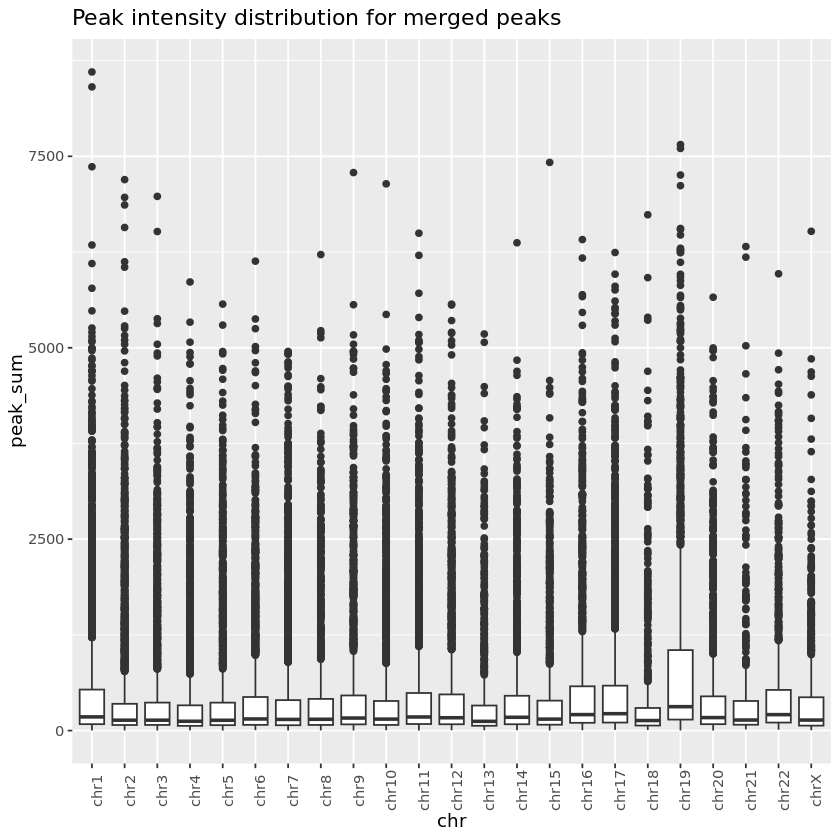

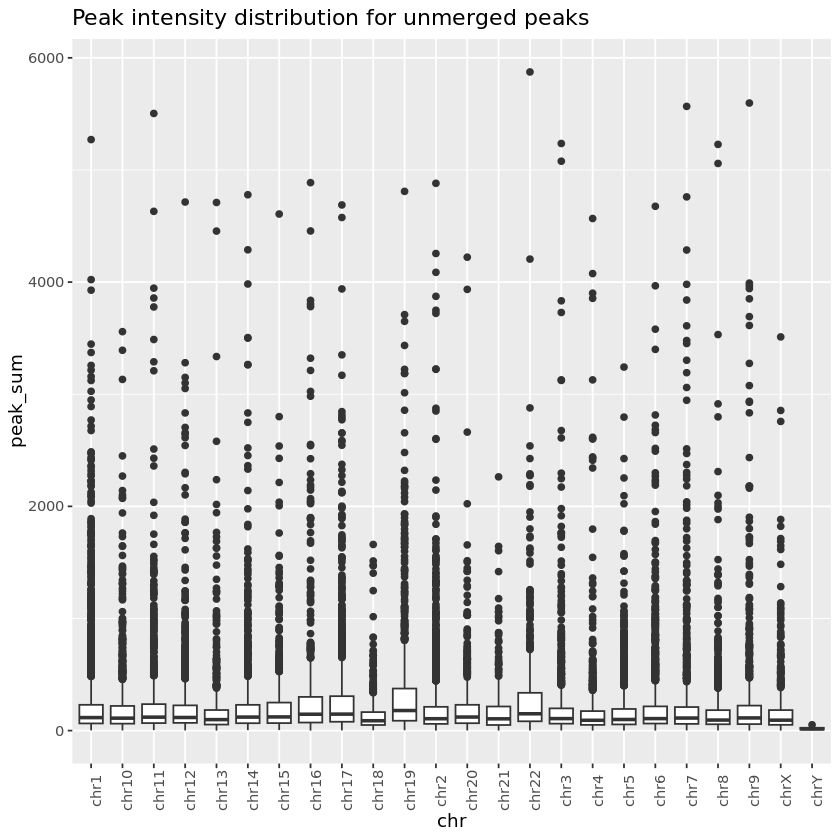

In [157]:
print(plot_s7_pea)

In [162]:
s7.summary.plot.genes <- function(
    data = merged_data
) {
    plot <- list()
    
    # atac
    data_atac <- data[peak_sum > 0 & grepl("chr", data$chr)]
    merged <- ggplot(data_atac, aes(x=chr, y=gene_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Expression of Genes with ATAC Peaks")
    
    # no atac
    data_no_atac <- data[(is.na(peak_sum)| peak_sum == 0) & grepl("chr", data$chr)]
    unmerged <- ggplot(data_no_atac, aes(x=chr, y=gene_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Expression of Genes without ATAC Peaks")

    #Save
    ggsave("/sharedFolder/Results/s7_gene_expression_merged.png", plot = merged)
    ggsave("/sharedFolder/Results/s7_gene_expression_unmerged.png", plot = unmerged)
    
    return(list(merged, unmerged))
}

In [163]:
plot_s7_genes <- s7.summary.plot.genes(merged_data)


Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]

[[2]]


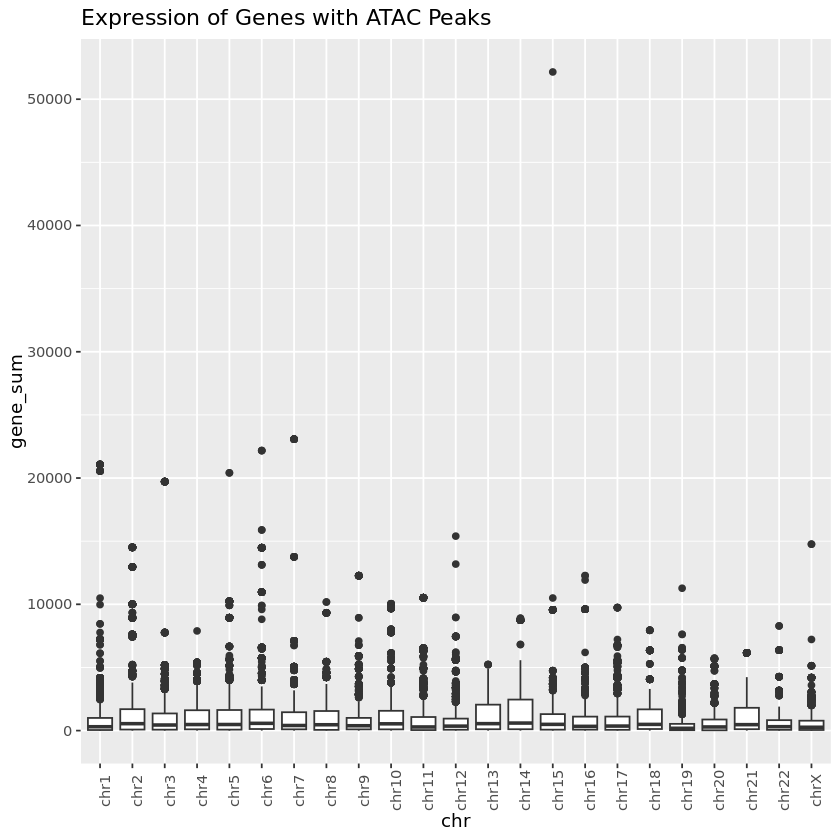

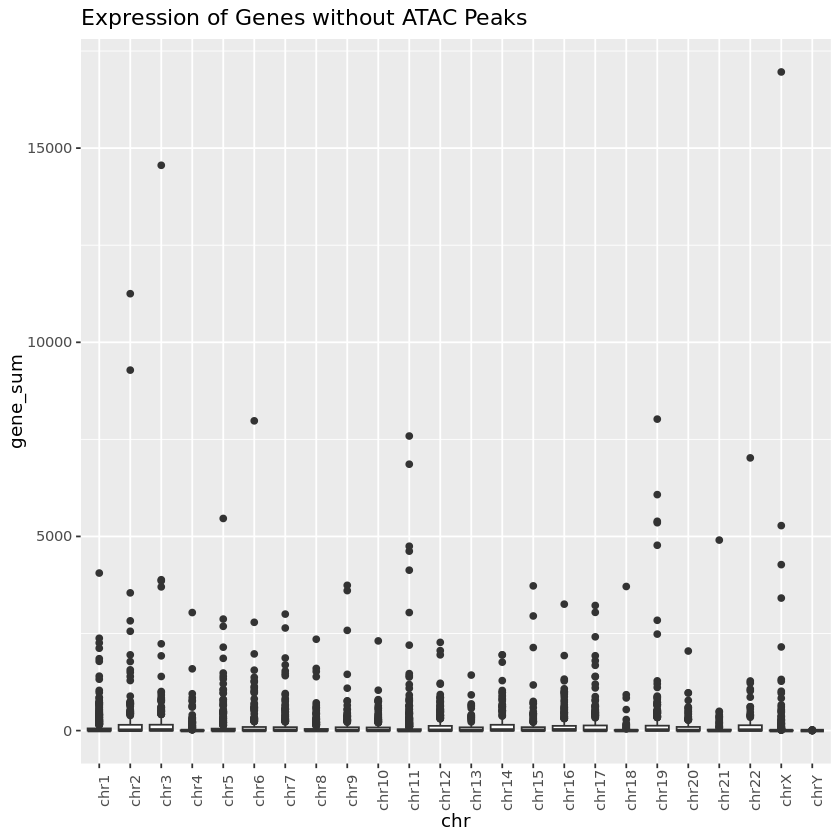

In [164]:
print(plot_s7_genes)

In [142]:
s7.summary.chr.wise <- function(

) {
    peak_chr_summary <- unmerged_peaks[, .N, by = chr]
    colnames(peak_chr_summary) <- c("chr", "N_unmerged_peaks")
    
    gr_genes_dt <- as.data.table(gr_genes)
    genes_no_atac <- merge(genes_no_atac, gr_genes_dt[, .(gene_id, seqnames)], by = "gene_id", all.x = TRUE)
    gene_chr_summary <- genes_no_atac[, .N, by = seqnames] 
    colnames(gene_chr_summary) <- c("chr", "N_unmerged_genes")
    
    chr_wise_summary <- merge(gene_chr_summary,peak_chr_summary, all = T)

    return(chr_wise_summary)
}

In [143]:
chr_wise_summary <- s7.summary.chr.wise()
print(chr_wise_summary)

Key: <chr>
           chr N_unmerged_genes N_unmerged_peaks
        <fctr>            <int>            <int>
 1:       chr1              607             3038
 2:       chr2              354             2444
 3:       chr3              303             1636
 4:       chr4              260             1092
 5:       chr5              319             1520
 6:       chr6              329             2007
 7:       chr7              280             1361
 8:       chr8              213             1283
 9:       chr9              243             1243
10:      chr10              193             1381
11:      chr11              538             1304
12:      chr12              311             1469
13:      chr13               81              740
14:      chr14              202             1098
15:      chr15              168              889
16:      chr16              274              807
17:      chr17              359             1404
18:      chr18               67              533
19:      

## 1st try

In [23]:
dt_genes_cmp <- NormalizeData(dt_genes[,-"id"], normalization.method = "LogNormalize", scale.factor = 1e6) %>% as.data.table
dt_genes_cmp[, id := dt_genes$id]
setcolorder(dt_genes_cmp, c("id", setdiff(names(dt_genes_cmp), "id")))

In [24]:
dt_atac_cmp <- NormalizeData(dt_atac[,-"id"], normalization.method = "LogNormalize", scale.factor = 1e6) %>% as.data.table
dt_atac_cmp[, id := dt_atac$id]
setcolorder(dt_atac_cmp, c("id", setdiff(names(dt_atac_cmp), "id")))

In [25]:
merge <- merge(dt_genes_cmp, dt_genes_cmp, by = "id", all = TRUE)

In [26]:
head(dt_genes_cmp)
head(dt_atac_cmp)

id,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,⋯,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCACTTCAT-1,TTTGTGTTCATGCGTG-1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000243485,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000186092,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000239945,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000239906,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


id,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,⋯,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCACTTCAT-1,TTTGTGTTCATGCGTG-1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:9782-10672,0,0,0,0,0,0,0,0,0,⋯,0,4.836964,0,0,0,0,0,0,0,0
chr1:180547-181446,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:191121-191998,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:267553-268447,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:270906-271782,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:273943-274789,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0


In [27]:
dt_atac_cmp[dt_atac_cmp$id == "chr1:9782-10672", 1:5]

id,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:9782-10672,0,0,0,0


In [28]:
nrow(merge)
ncol(merge)
head(merge)

[1] 36601

[1] 6019

id,AAACAGCCAACAGGTG-1.x,AAACATGCAACAACAA-1.x,AAACATGCACCTGGTG-1.x,AAACCAACACAGCCTG-1.x,AAACCAACAGCAAGAT-1.x,AAACCAACATTGCGAC-1.x,AAACCGAAGCACAGCC-1.x,AAACCGCGTAATTAGC-1.x,AAACCGCGTCACGAAC-1.x,⋯,TTTGGTGCATGAGCAG-1.y,TTTGTCCCAGCTTAGC-1.y,TTTGTCCCATAATCGT-1.y,TTTGTCTAGCATGTTA-1.y,TTTGTCTAGGAGGACT-1.y,TTTGTCTAGTCTATGA-1.y,TTTGTGGCAGCACGAA-1.y,TTTGTGGCATCGCTCC-1.y,TTTGTGTTCACTTCAT-1.y,TTTGTGTTCATGCGTG-1.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,0,0.000000,0,0,0,0,0.000000,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000005,0,0.000000,0,0,0,0,0.000000,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000419,0,0.000000,0,0,0,0,0.000000,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,5.602846,0
ENSG00000000457,0,0.000000,0,0,0,0,5.455749,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000460,0,0.000000,0,0,0,0,6.146758,0,0,⋯,0.000000,6.099516,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000938,0,6.622155,0,0,0,0,0.000000,0,0,⋯,5.405075,0.000000,0,5.628756,0,0,0,0,5.602846,0


## 2nd try

### normalize
* Normalize both expression and ATAC-seq data using CPM:
    * Divide each column by the column sum, multiply by 106, add a pseudo-count of 1, and apply log2.

In [50]:
# Remove id column for matrix operations
gene_mat <- as.matrix(dt_genes[ , -'id', with=FALSE])
atac_mat <- as.matrix(dt_atac[ , -'id', with=FALSE])

In [51]:
# CPM normalization: for each cell
gene_cpm <- t(t(gene_mat) / colSums(gene_mat)) * 1e6
gene_cpm <- log2(gene_cpm + 1)  # log transform

In [53]:
head(gene_cpm)

AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,AAACCGGCAGAGGGAG-1,⋯,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCACTTCAT-1,TTTGTGTTCATGCGTG-1
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [52]:
# CPM normalization: for each cell
atac_cpm <- t(t(atac_mat) / colSums(atac_mat)) * 1e6
atac_cpm <- log2(atac_cpm + 1)

In [54]:
head(atac_cpm)

AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,AAACCGGCAGAGGGAG-1,⋯,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCACTTCAT-1,TTTGTGTTCATGCGTG-1
0,0,0,0,0,0,0,0,0,0,⋯,0,6.978981,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0


### merge
* Merge expression and ATAC data based on common genes.

In [55]:
merged <- merge(
  as.data.table(gr_genes)[, .(gene_id, gene_symbol, gene_sum = sum)],
  as.data.table(gr_atac)[, .(nearest_gene, peak_sum = sum)],
  by.x = "gene_id", by.y = "nearest_gene", all.x = TRUE
)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'y' in selecting a method for function 'merge': object 'nearest_gene' not found


In [71]:
merged <- merge(
  as.data.table(gr_genes)[, .(gene_id, gene_symbol, gene_sum = sum)],
  as.data.table(gr_atac)[, .(overlapping_genes, peak_sum = sum)],
  by.x = "gene_id", by.y = "overlapping_genes", all.x = TRUE
)

In [72]:
head(merged)

gene_id,gene_symbol,expr,peak_sum
<chr>,<chr>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,0,108
ENSG00000000005,TNMD,0,NA
ENSG00000000419,DPM1,424,NA
ENSG00000000457,SCYL3,215,190
ENSG00000000457,SCYL3,215,3340
ENSG00000000460,FIRRM,365,252


### summary table
* Provide a summary table of the number of ATAC peaks that could not be merged and a plot of peak intensity distribution chromosome by chromosome. Provide a summary table of the genes which do not show association with ATAC peaks and plot their expression distribution chromosome by chromosome

#### 1st

In [30]:
# Summary Table of Unmerged ATAC Peaks
# Peaks without annotated gene
unmerged_atac <- gr_atac[is.na(gr_atac$nearest_gene)]
table(seqnames(unmerged_atac))


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
 3038  1381  1304  1469   740  1098   889   807  1404   533   989  2444   903 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
  369   639  1636  1092  1520  2007  1361  1283  1243   879    14 

In [31]:
# Summary Table of Genes Without ATAC Peaks
genes_with_no_peak <- gr_genes[!(gr_genes$gene_id %in% gr_atac$nearest_gene)]
genes_with_no_peak <- genes_with_no_peak[grepl("chr",seqnames(genes_with_no_peak))]
table(seqnames(genes_with_no_peak))


      chr1       chr2       chr3       chr4       chr5       chr6       chr7 
       462        254        189        222        249        235        215 
      chr8       chr9      chr10      chr11      chr12      chr13      chr14 
       172        184        147        441        230         58        138 
     chr15      chr16      chr17      chr18      chr19      chr20      chr21 
       122        188        231         57        285        117         79 
     chr22       chrX       chrY    unknown GL000009.2 GL000194.1 GL000195.1 
        73        327         43          0          0          0          0 
GL000205.2 GL000213.1 GL000218.1 GL000219.1 KI270711.1 KI270713.1 KI270721.1 
         0          0          0          0          0          0          0 
KI270726.1 KI270727.1 KI270728.1 KI270731.1 KI270734.1 
         0          0          0          0          0 

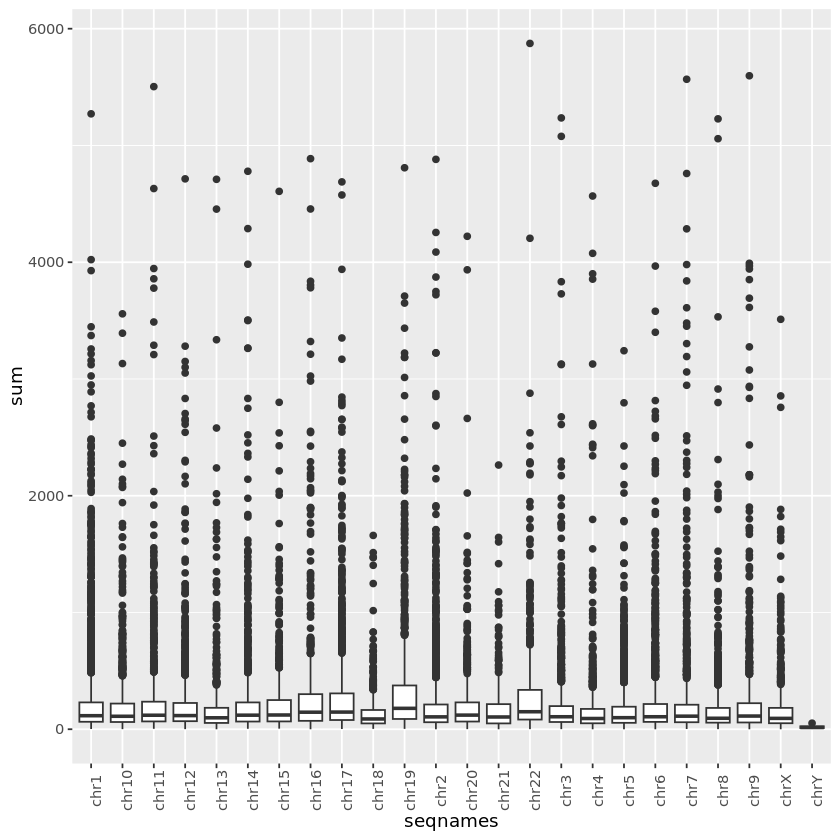

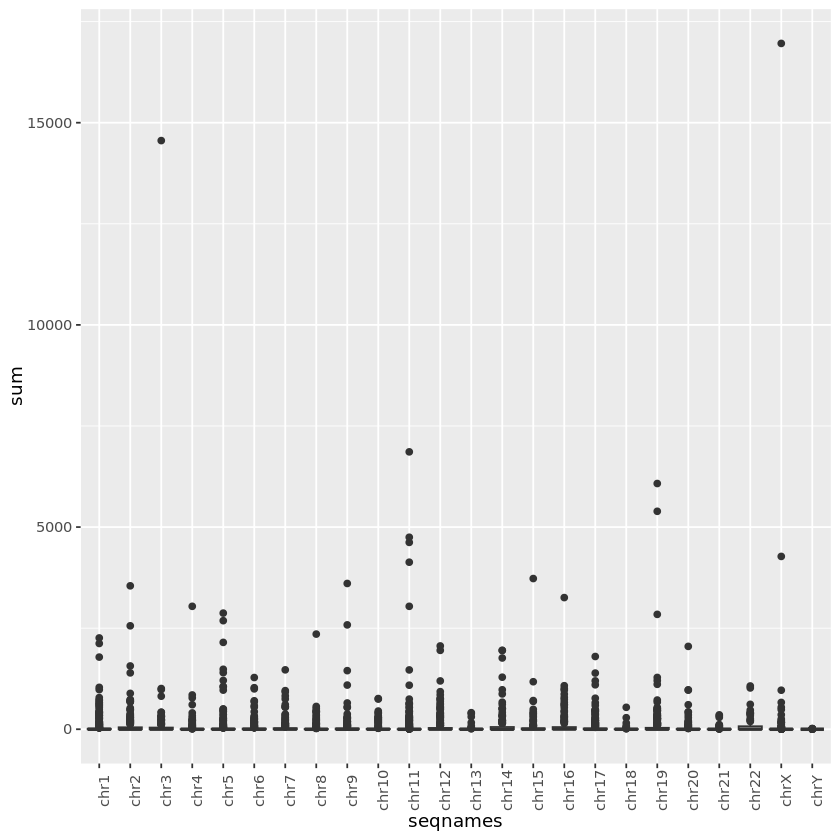

In [32]:
library(ggplot2)
# Distribution of unmerged ATAC peaks by chromosome
ggplot(as.data.frame(unmerged_atac), aes(x=seqnames, y=sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

# Distribution of unassociated gene expression by chromosome
ggplot(as.data.frame(genes_with_no_peak), aes(x=seqnames, y=sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

#### 2sd

In [53]:
# Assuming gr_atac is your GRanges with peak annotations:
unmerged_peaks <- as.data.table(gr_atac)[is.na(overlapping_genes)]

# How many?
n_unmerged_peaks <- nrow(unmerged_peaks)

# Summary table: can include peak_id, coordinates, and optionally signal
unmerged_peaks_summary <- unmerged_peaks[, .(peak_id, seqnames, start, end, peak_sum)] # adjust columns as needed
colnames(unmerged_peaks_summary)[colnames(unmerged_peaks_summary) == "seqnames"] <- "chr"

# Print summary
cat("Number of ATAC peaks not merged with any gene:", n_unmerged_peaks, "\n")
head(unmerged_peaks_summary)

Number of ATAC peaks not merged with any gene: 29042 


peak_id,chr,start,end,peak_sum
<chr>,<fct>,<int>,<int>,<dbl>
chr1:9782-10672,chr1,9782,10672,46
chr1:180547-181446,chr1,180547,181446,83
chr1:191121-191998,chr1,191121,191998,20
chr1:267553-268447,chr1,267553,268447,74
chr1:270906-271782,chr1,270906,271782,26
chr1:273943-274789,chr1,273943,274789,25


In [194]:
colnames(unmerged_peaks_summary)[colnames(unmerged_peaks_summary) == "seqnames"] <- "chr"
head(unmerged_peaks_summary)

peak_id,chr,start,end,sum
<chr>,<fct>,<int>,<int>,<dbl>
chr1:9782-10672,chr1,9782,10672,46
chr1:180547-181446,chr1,180547,181446,83
chr1:191121-191998,chr1,191121,191998,20
chr1:267553-268447,chr1,267553,268447,74
chr1:270906-271782,chr1,270906,271782,26
chr1:273943-274789,chr1,273943,274789,25


In [48]:
head(merged_data)
sum(is.na(merged_data$peak_sum))
sum(merged_data$peak_sum == 0)
nrow(merged_data)
merged_data[peak_sum ==0]

gene_id,gene_symbol,gene_sum,peak_sum
<chr>,<chr>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,0,108
ENSG00000000005,TNMD,0,NA
ENSG00000000419,DPM1,424,NA
ENSG00000000457,SCYL3,215,190
ENSG00000000457,SCYL3,215,3340
ENSG00000000460,FIRRM,365,252


[1] 6348

[1] NA

[1] 52397

gene_id,gene_symbol,gene_sum,peak_sum
<chr>,<chr>,<dbl>,<dbl>
ENSG00000145934,TENM2,19,0


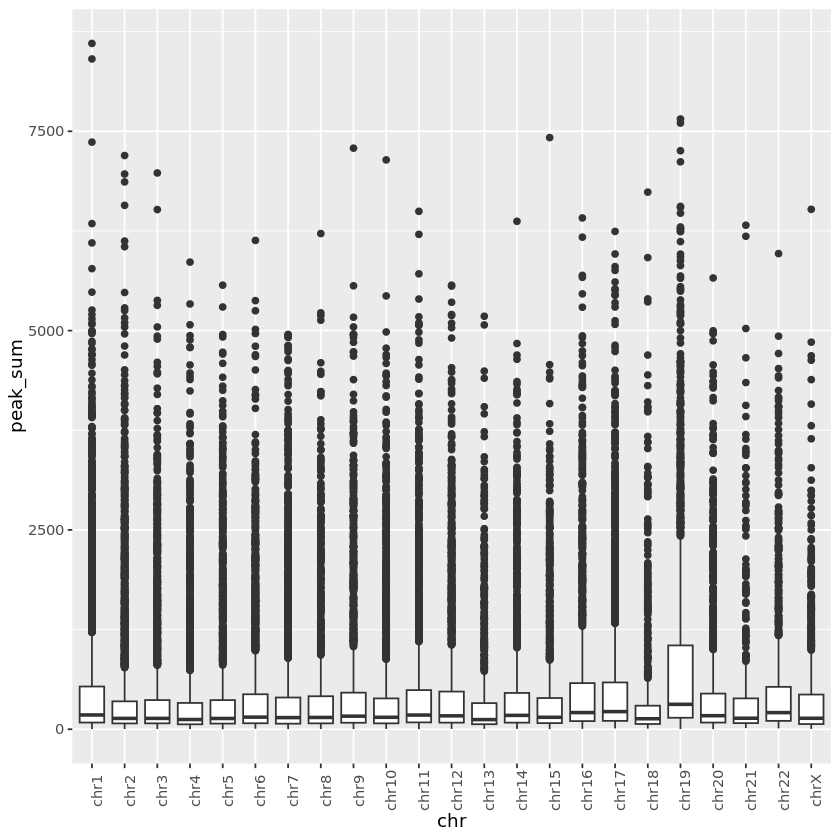

In [79]:
# merged
merg_provv <- merged_data[!is.na(peak_sum)]
ggplot(merg_provv, aes(x=chr, y=peak_sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

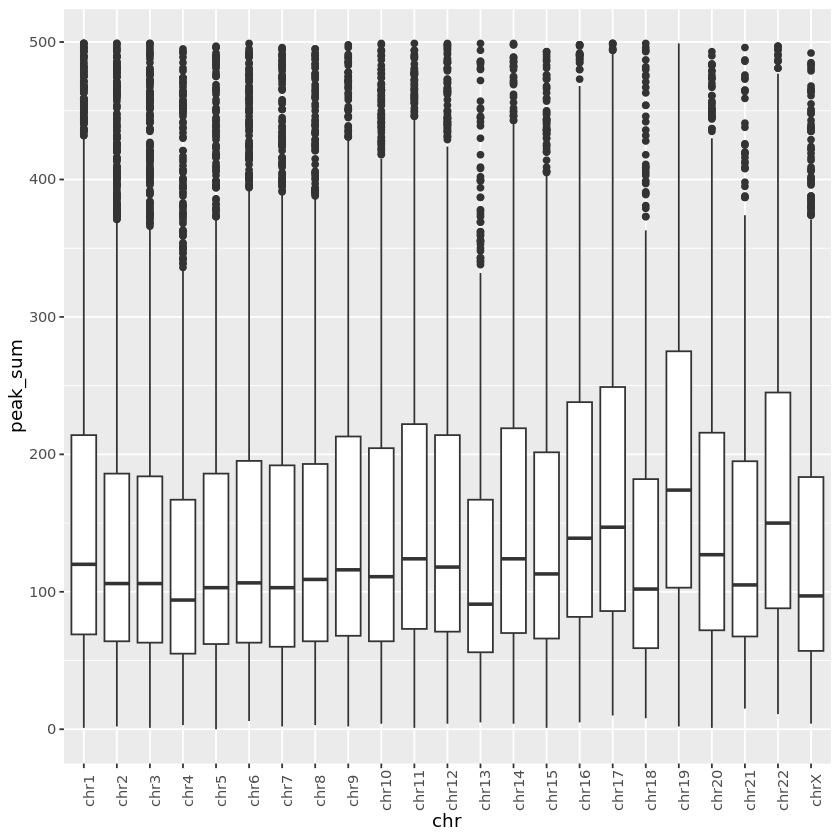

In [84]:
# merged
merg_provv <- merged_data[!is.na(peak_sum) & peak_sum < 500]
ggplot(merg_provv, aes(x=chr, y=peak_sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

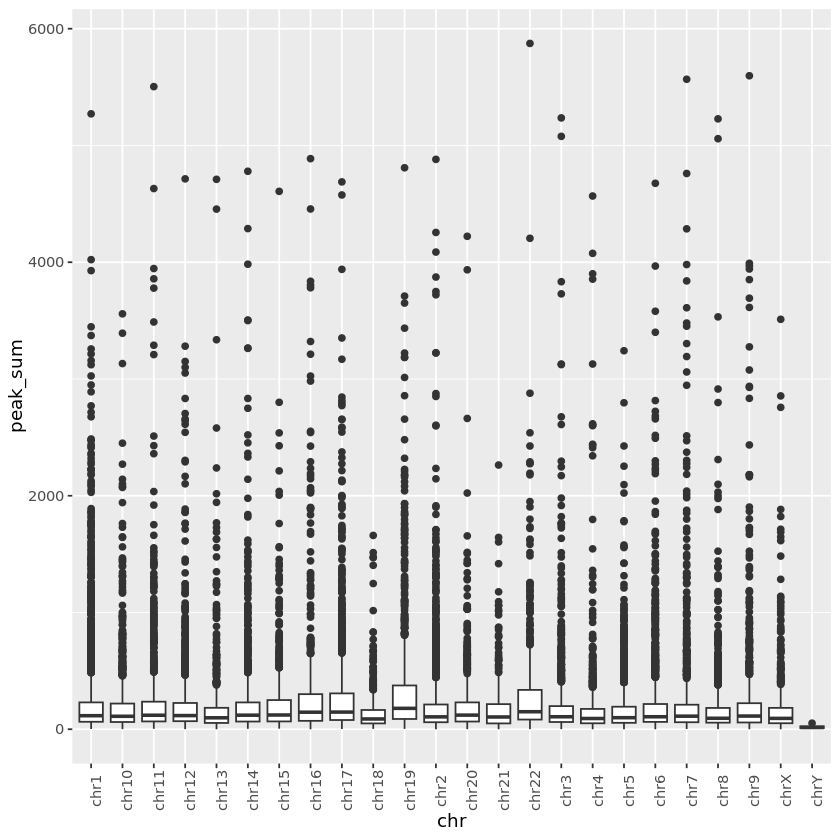

In [60]:
# unmerged
ggplot(unmerged_peaks_summary, aes(x=chr, y=peak_sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

In [54]:
# After the merge step:
# merged: contains gene_id, gene_symbol, gene_sum, peak_sum (from your previous merge)
print("a")
genes_no_atac <- merged_data[is.na(peak_sum) | peak_sum == 0]
print("a")
# How many?
n_genes_no_atac <- nrow(genes_no_atac)
print("a")
# Summary table: gene_id, gene_symbol, gene_sum
genes_no_atac_summary <- genes_no_atac[, .(gene_id, gene_symbol, gene_sum)]
print("a")
# Print summary
cat("Number of genes without associated ATAC peaks:", n_genes_no_atac, "\n")
head(genes_no_atac_summary)

[1] "a"
[1] "a"
[1] "a"
[1] "a"
Number of genes without associated ATAC peaks: 6349 


gene_id,gene_symbol,gene_sum
<chr>,<chr>,<dbl>
ENSG00000000005,TNMD,0
ENSG00000000419,DPM1,424
ENSG00000000971,CFH,39
ENSG00000001167,NFYA,298
ENSG00000001626,CFTR,7
ENSG00000001629,ANKIB1,1536


In [95]:
(TRUE & FALSE) | FALSE

[1] FALSE

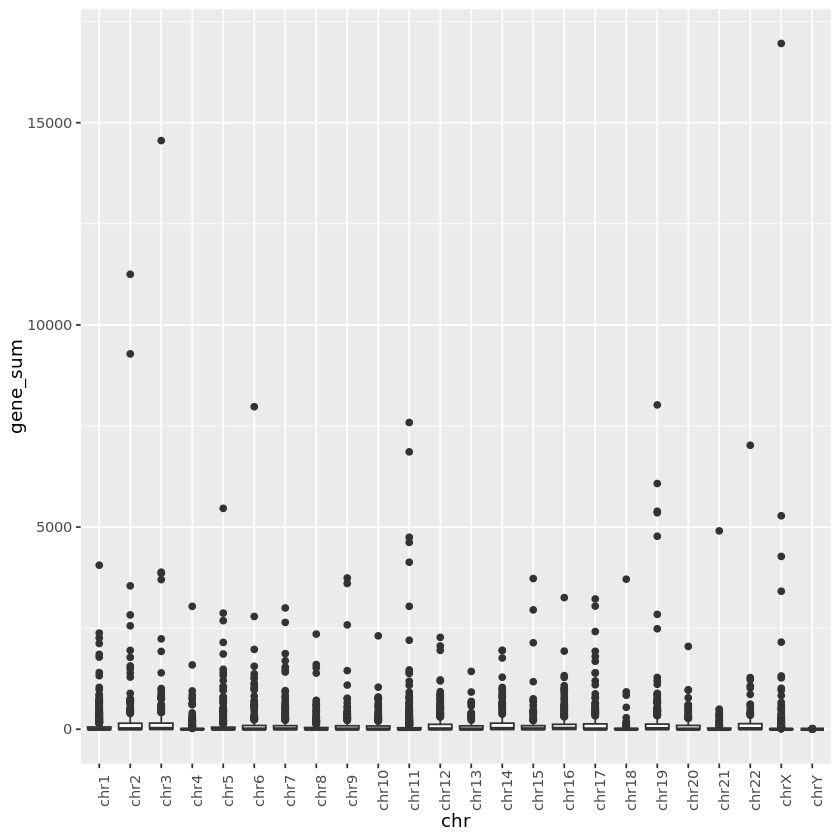

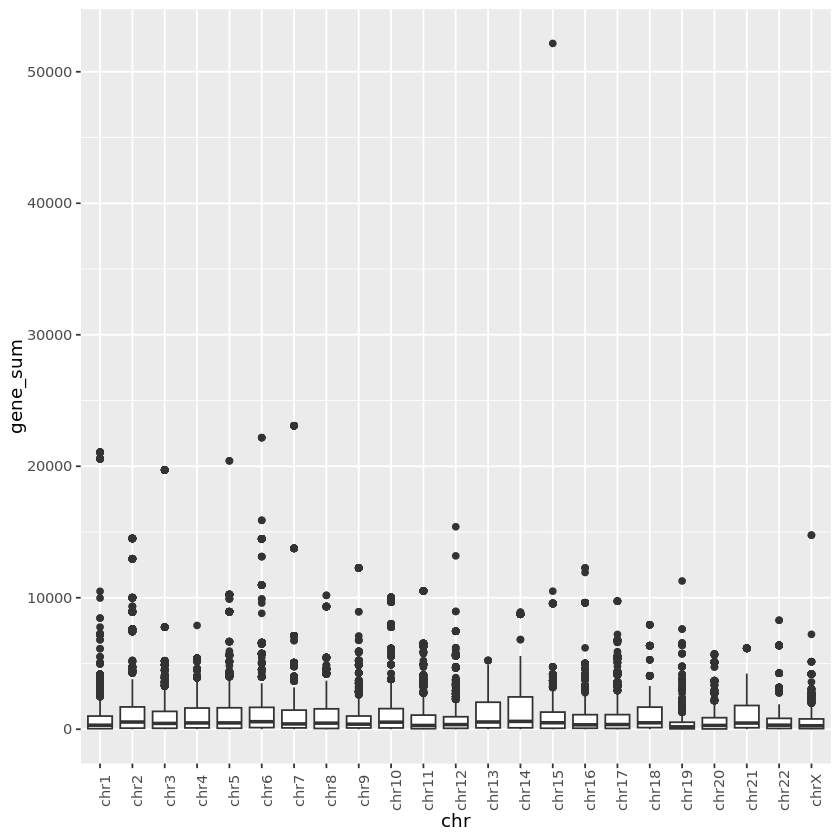

In [99]:
# no atac
merg_provv <- merged_data[(is.na(peak_sum)| peak_sum == 0) & grepl("chr", merged_data$chr)]
ggplot(merg_provv, aes(x=chr, y=gene_sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

# atac
merg_provv <- merged_data[peak_sum > 0 & grepl("chr", merged_data$chr)]
ggplot(merg_provv, aes(x=chr, y=gene_sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

In [55]:
# Chromosome-wise Summaries
peak_chr_summary <- unmerged_peaks[, .N, by = seqnames]
colnames(peak_chr_summary) <- c("chr", "N_unmerged_peaks")

# Suppose gr_genes is your GRanges with gene_id and seqnames
gr_genes_dt <- as.data.table(gr_genes)
head(gr_genes_dt)
nrow(gr_genes_dt)
genes_no_atac <- merge(genes_no_atac, gr_genes_dt[, .(gene_id, seqnames)], by = "gene_id", all.x = TRUE)
gene_chr_summary <- genes_no_atac[, .N, by = seqnames] # If you have seqnames in merged table
colnames(gene_chr_summary) <- c("chr", "N_unmerged_genes")

chr_wise_summary <- merge(gene_chr_summary,peak_chr_summary, all = T)
print(chr_wise_summary)

seqnames,start,end,width,strand,gene_sum,gene_id,gene_name,gene_symbol
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,<chr>
chr1,65418,69055,3638,*,0,ENSG00000186092,OR4F5,OR4F5
chr1,451696,451697,2,*,0,ENSG00000284733,OR4F29,OR4F29
chr1,686672,686673,2,*,0,ENSG00000284662,OR4F16,OR4F16
chr1,925730,925741,12,*,4,ENSG00000187634,SAMD11,SAMD11
chr1,959255,959256,2,*,384,ENSG00000188976,NOC2L,NOC2L
chr1,960583,960639,57,*,26,ENSG00000187961,KLHL17,KLHL17


[1] 19188

Key: <chr>
           chr N_unmerged_genes N_unmerged_peaks
        <fctr>            <int>            <int>
 1:       chr1              607             3038
 2:       chr2              354             2444
 3:       chr3              303             1636
 4:       chr4              260             1092
 5:       chr5              319             1520
 6:       chr6              329             2007
 7:       chr7              280             1361
 8:       chr8              213             1283
 9:       chr9              243             1243
10:      chr10              193             1381
11:      chr11              538             1304
12:      chr12              311             1469
13:      chr13               81              740
14:      chr14              202             1098
15:      chr15              168              889
16:      chr16              274              807
17:      chr17              359             1404
18:      chr18               67              533
19:      

In [87]:
peak_chr_summary <- unmerged_peaks[, .N, by = seqnames]
colnames(peak_chr_summary) <- c("chr", "peak_chr_summary")
print(peak_chr_summary)

       chr peak_chr_summary
    <fctr>            <int>
 1:   chr1             3038
 2:  chr10             1381
 3:  chr11             1304
 4:  chr12             1469
 5:  chr13              740
 6:  chr14             1098
 7:  chr15              889
 8:  chr16              807
 9:  chr17             1404
10:  chr18              533
11:  chr19              989
12:   chr2             2444
13:  chr20              903
14:  chr21              369
15:  chr22              639
16:   chr3             1636
17:   chr4             1092
18:   chr5             1520
19:   chr6             2007
20:   chr7             1361
21:   chr8             1283
22:   chr9             1243
23:   chrX              879
24:   chrY               14
       chr peak_chr_summary


In [93]:
print(peak_chr_summary[order(chr)])

       chr peak_chr_summary
    <fctr>            <int>
 1:   chr1             3038
 2:  chr10             1381
 3:  chr11             1304
 4:  chr12             1469
 5:  chr13              740
 6:  chr14             1098
 7:  chr15              889
 8:  chr16              807
 9:  chr17             1404
10:  chr18              533
11:  chr19              989
12:   chr2             2444
13:  chr20              903
14:  chr21              369
15:  chr22              639
16:   chr3             1636
17:   chr4             1092
18:   chr5             1520
19:   chr6             2007
20:   chr7             1361
21:   chr8             1283
22:   chr9             1243
23:   chrX              879
24:   chrY               14
       chr peak_chr_summary


In [90]:
# Suppose gr_genes is your GRanges with gene_id and seqnames
gr_genes_dt <- as.data.table(gr_genes)
genes_no_atac <- merge(genes_no_atac, gr_genes_dt[, .(gene_id, seqnames)], by = "gene_id", all.x = TRUE)

In [91]:
gene_chr_summary <- genes_no_atac[, .N, by = seqnames] # If you have seqnames in merged table
colnames(gene_chr_summary) <- c("chr", "gene_chr_summary")
print(gene_chr_summary)

           chr gene_chr_summary
        <fctr>            <int>
 1:       chrX              382
 2:      chr20              159
 3:       chr1              607
 4:       chr6              329
 5:       chr7              280
 6:      chr11              538
 7:      chr12              311
 8:       chr2              354
 9:       chr8              213
10:      chr17              359
11:      chr16              274
12:      chr19              443
13:      chr13               81
14:       chr5              319
15:       chr3              303
16:       chrY               43
17:      chr14              202
18:      chr10              193
19:      chr22              113
20:       chr4              260
21:      chr18               67
22:       chr9              243
23:      chr15              168
24:      chr21               94
25:    unknown               13
26: GL000194.1                1
           chr gene_chr_summary


In [92]:
print(gene_chr_summary[order(chr)])

           chr gene_chr_summary
        <fctr>            <int>
 1:       chr1              607
 2:       chr2              354
 3:       chr3              303
 4:       chr4              260
 5:       chr5              319
 6:       chr6              329
 7:       chr7              280
 8:       chr8              213
 9:       chr9              243
10:      chr10              193
11:      chr11              538
12:      chr12              311
13:      chr13               81
14:      chr14              202
15:      chr15              168
16:      chr16              274
17:      chr17              359
18:      chr18               67
19:      chr19              443
20:      chr20              159
21:      chr21               94
22:      chr22              113
23:       chrX              382
24:       chrY               43
25:    unknown               13
26: GL000194.1                1
           chr gene_chr_summary


In [96]:
print(merge(gene_chr_summary,peak_chr_summary, all = T))

Key: <chr>
           chr gene_chr_summary peak_chr_summary
        <fctr>            <int>            <int>
 1:       chr1              607             3038
 2:       chr2              354             2444
 3:       chr3              303             1636
 4:       chr4              260             1092
 5:       chr5              319             1520
 6:       chr6              329             2007
 7:       chr7              280             1361
 8:       chr8              213             1283
 9:       chr9              243             1243
10:      chr10              193             1381
11:      chr11              538             1304
12:      chr12              311             1469
13:      chr13               81              740
14:      chr14              202             1098
15:      chr15              168              889
16:      chr16              274              807
17:      chr17              359             1404
18:      chr18               67              533
19:      

In [95]:
?merge

Vector-merge {S4Vectors},R Documentation
"x, y, ...","Vector-like objects, typically all of the same class and typically not list-like objects (even though some list-like objects like IntegerRanges and DNAStringSet are supported). Duplicated elements in each object are removed with a warning."
all,"TRUE or FALSE. Whether the vector elements in the result should be the union (when all=TRUE) or intersection (when all=FALSE) of the vector elements in x, y, ...."
"all.x, all.y","To be used only when merging 2 objects (binary merge). Both all.x and all.y must be single logicals. If any of them is NA, then it's set to the value of all. Setting both of them to TRUE or both of them to FALSE is equivalent to setting all to TRUE or to FALSE, respectively (see above). If all.x is TRUE and all.y is FALSE then the vector elements in the result will be the unique elements in x. If all.x is FALSE and all.y is TRUE then the vector elements in the result will be the unique elements in y."
sort,Whether to sort the merged result.


# Step 8: Visualization

* Generate a scatter plot using ggplot2:
    * X-axis: log-transformed expression CPM
    * Y-axis: log-transformed ATAC CPM
* If the plot is too much busy of data divide the plot in the 24 chromosomes

## function

In [206]:
s8.scatter.plots <- function(chr_num) {
    plot <- ggplot(merged_data[!is.na(peak_sum) & merged_data$chr == paste0("chr", chr_num)], aes(x=gene_sum, y=peak_sum)) +
      geom_point(alpha=0.5) +
      labs(x = "Gene Expression CPM (log)", y = "ATAC Peaks CPM (log)", title = paste("Chromosme", chr_num)) +
      #facet_wrap(~ chr) +
      theme_bw() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
    return(plot)
}

In [207]:
s8.save.plots <- function() {
    plot_list <- lapply(c(as.character(1:22), "X", "Y"), s8.scatter.plots)

    for (i in 1:(length(plot.list)/12)) {
        n <- 12*(i-1)+1
        combined <- cowplot::plot_grid(plotlist = plot.list[(n):(n+11)], ncol = 3) 
        ggsave(paste0(
            "/sharedFolder/Results/s8.plot_",
            i,
            ".png"
        ), plot = combined, width = 1920*2, height = 1080*3.6, units = "px")
    }
}

In [208]:
s8.save.plots()

## do

In [202]:
for (i in 1:3) {print(paste(12*(i-1)+1, 12*(i-1)+1+11))}

[1] "1 12"
[1] "13 24"
[1] "25 36"


## old

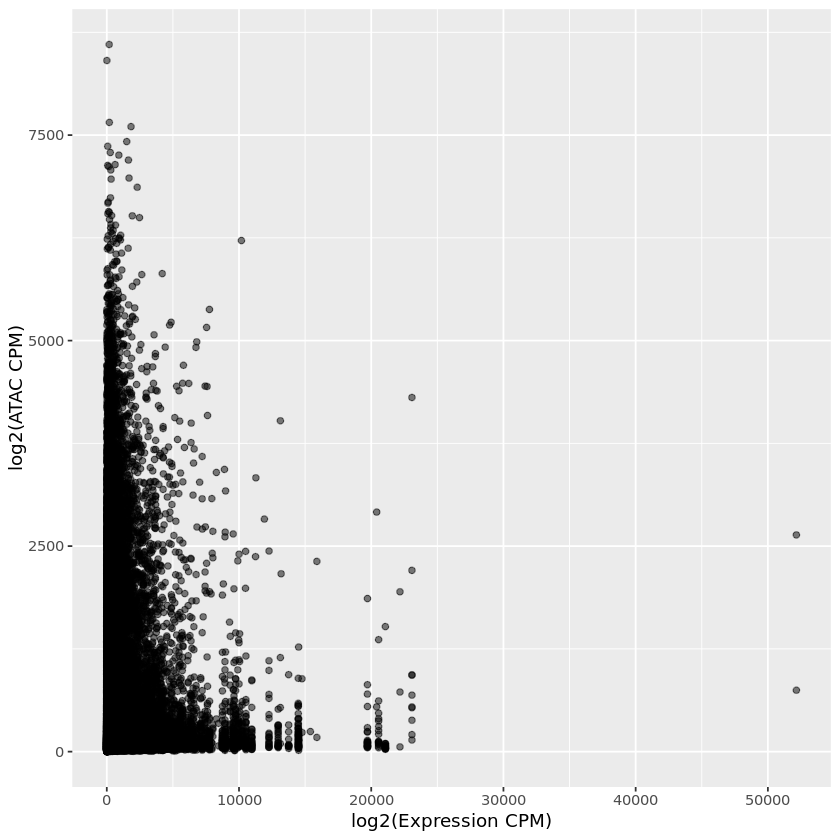

In [33]:
ggplot(merged[!is.na(peak_sum)], aes(x=gene_sum, y=peak_sum)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)")

In [34]:
head(merged)

gene_id,gene_symbol,expr,peak_sum
<chr>,<chr>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,0,108
ENSG00000000005,TNMD,0,NA
ENSG00000000419,DPM1,424,NA
ENSG00000000457,SCYL3,215,190
ENSG00000000457,SCYL3,215,3340
ENSG00000000460,FIRRM,365,252


In [35]:
names(merged)

[1] "gene_id"     "gene_symbol" "expr"        "peak_sum"

In [36]:
# Extract chromosome info from gr_genes
genes_chr <- data.frame(
  gene_id = gr_genes$gene_id,
  chr = as.character(GenomicRanges::seqnames(gr_genes))
)

In [37]:
# Remove 'chr' column from merged if it exists
if ("chr" %in% colnames(merged)) merged$chr <- NULL

In [38]:
head(genes_chr)

,gene_id,chr
,<chr>,<chr>
1,ENSG00000186092,chr1
2,ENSG00000284733,chr1
3,ENSG00000284662,chr1
4,ENSG00000187634,chr1
5,ENSG00000188976,chr1
6,ENSG00000187961,chr1


In [39]:
# Merge chromosome info into your merged data frame
merged <- merge(
  merged,
  genes_chr,
  by = "gene_id",
  all.x = TRUE
)

In [40]:
head(merged)

gene_id,gene_symbol,expr,peak_sum,chr
<chr>,<chr>,<dbl>,<dbl>,<chr>
ENSG00000000003,TSPAN6,0,108,chrX
ENSG00000000005,TNMD,0,NA,chrX
ENSG00000000419,DPM1,424,NA,chr20
ENSG00000000457,SCYL3,215,190,chr1
ENSG00000000457,SCYL3,215,3340,chr1
ENSG00000000460,FIRRM,365,252,chr1


In [41]:
unique(merged$chr)

[1] "chrX"       "chr20"      "chr1"       "chr6"       "chr3"      
 [6] "chr7"       "chr12"      "chr11"      "chr4"       "chr17"     
[11] "chr2"       "chr16"      "chr8"       "chr19"      "chr9"      
[16] "chr13"      "chr14"      "chr5"       "chr22"      "chr10"     
[21] "chrY"       "chr18"      "chr15"      "chr21"      "unknown"   
[26] "GL000194.1"

In [42]:
nrow(merged)
a <- 55201
sum(merged$chr==merged$chr)

[1] 55256

[1] 55256

In [43]:
nrow(merged[merged$chr == "NA",])

[1] 0

In [44]:
chr_num <- "chr1"
nrow(merged[merged$chr == chr_num,])
nrow(merged[merged$chr == chr_num & !is.na(merged$peak_sum),])

[1] 5310

[1] 4848

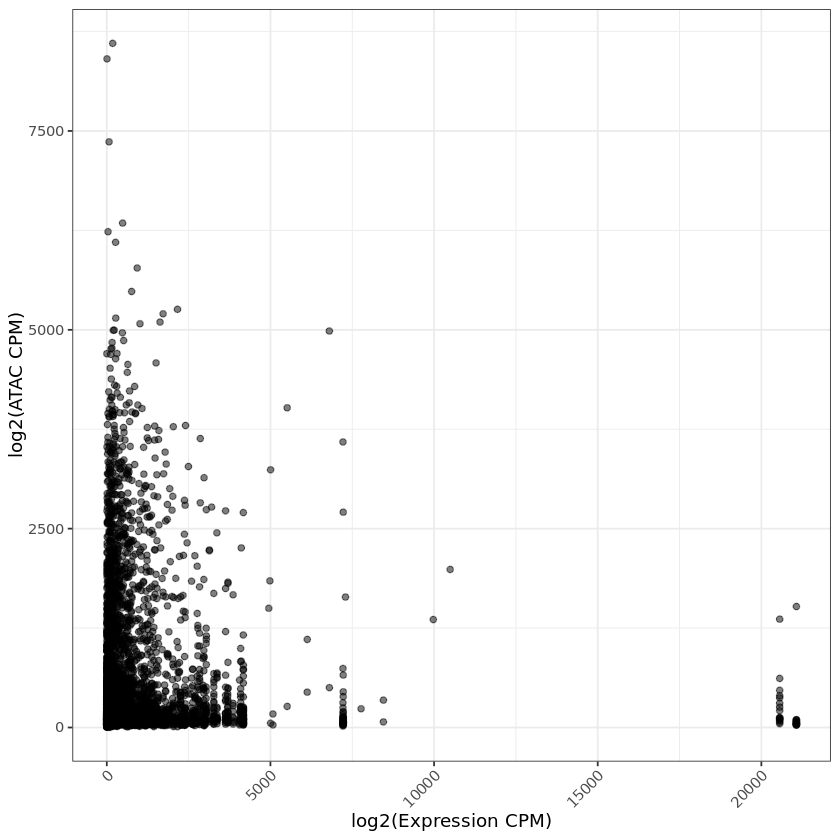

In [45]:
# Then plot as above
ggplot(merged[!is.na(peak_sum) & merged$chr == "chr1"], aes(x=gene_sum, y=peak_sum)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)") +
  #facet_wrap(~ chr) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

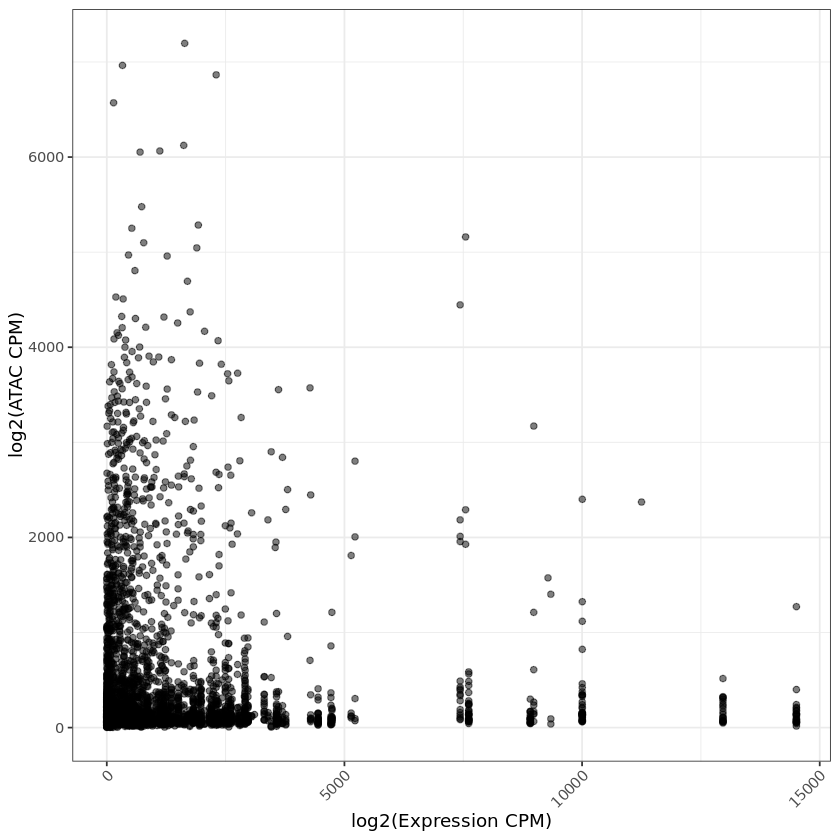

In [46]:
ggplot(merged[!is.na(peak_sum) & merged$chr == "chr2"], aes(x=gene_sum, y=peak_sum)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)") +
  #facet_wrap(~ chr) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

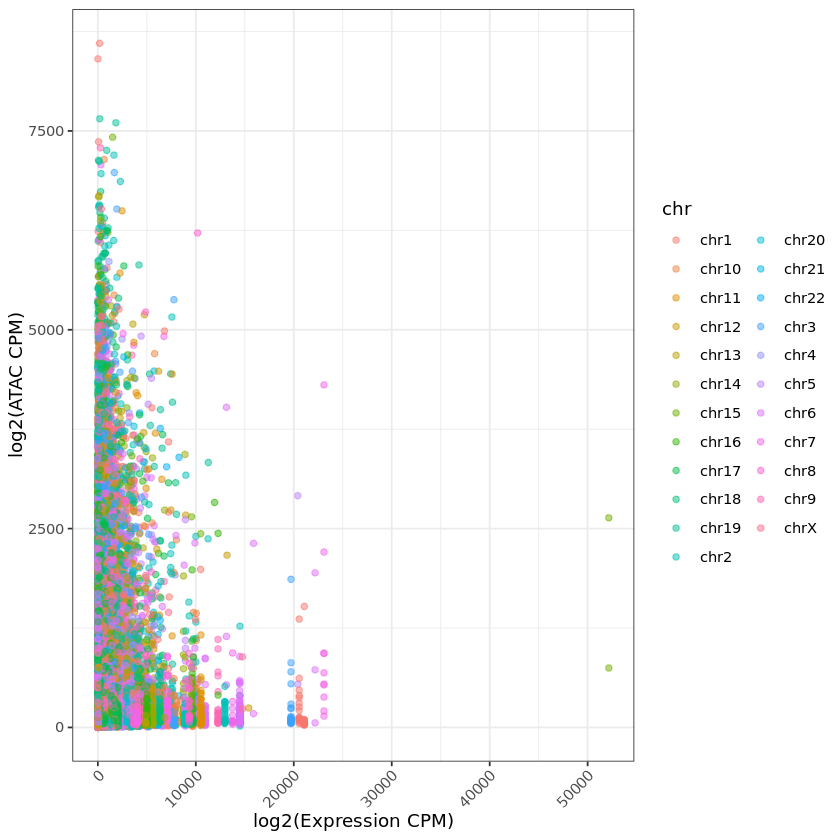

In [47]:
ggplot(merged[!is.na(peak_sum)], aes(x=gene_sum, y=peak_sum, color = chr)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)") +
  #facet_wrap(~ chr) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [48]:
print(paste("a", 1:5))

[1] "a 1" "a 2" "a 3" "a 4" "a 5"


## decente

In [193]:
p <- function(chr_num) {
    plot <- ggplot(merged_data[!is.na(peak_sum) & merged_data$chr == paste0("chr", chr_num)], aes(x=gene_sum, y=peak_sum)) +
      geom_point(alpha=0.5) +
      labs(x = "Gene Expression CPM (log)", y = "ATAC Peaks CPM (log)", title = paste("Chromosme", chr_num)) +
      #facet_wrap(~ chr) +
      theme_bw() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
    return(plot)
}

In [194]:
plot.list <- lapply(c(as.character(1:22), "X", "Y"), p)

In [195]:
length(plot.list)

[1] 24

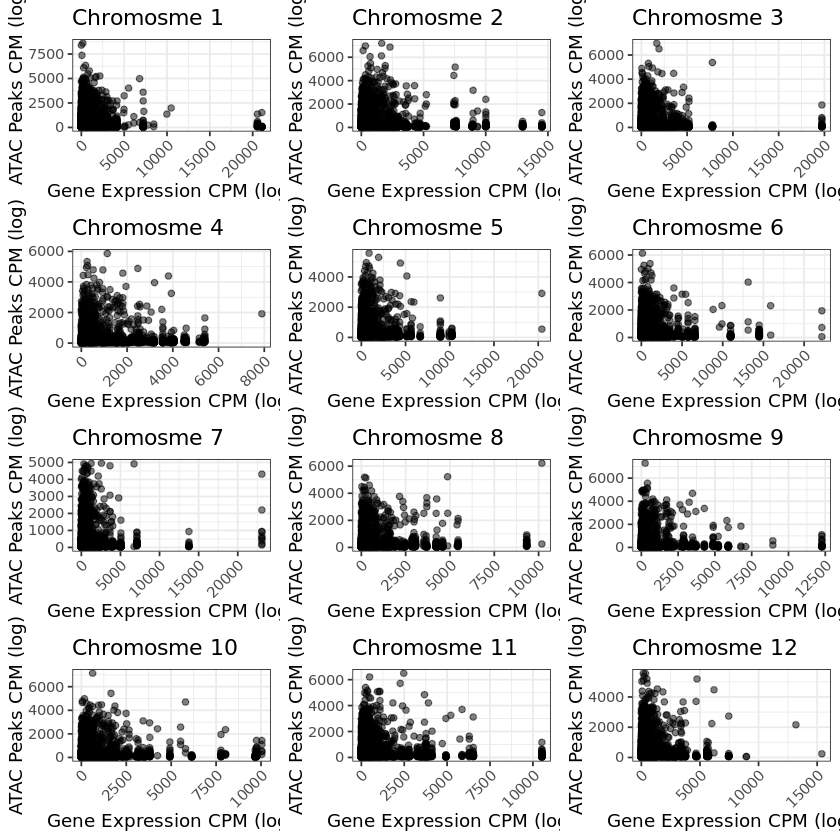

In [196]:
combined_1 <- cowplot::plot_grid(plotlist = plot.list[1:12], ncol = 3) 
print(combined_1)

In [190]:
ggsave("plot.png", plot = combined_1, width = 1920*2, height = 1080*3.6, units = "px")

In [81]:
ggsave("plot.png", plot = combined, width = 1920*2, height = 1080*3.6, units = "px")
# non si vede nulla, troppo piccolo

# R Markdown

In [82]:
#install.packages("tinytex")
#tinytex::install_tinytex()

In [188]:
rmarkdown::render("Maiolino_Au.Rmd")



processing file: Maiolino_Au.Rmd



1/30                   
2/30 [unnamed-chunk-1] 
3/30                   
4/30 [unnamed-chunk-2] 
5/30                   
6/30 [unnamed-chunk-3] 
7/30                   
8/30 [unnamed-chunk-4] 
9/30                   
10/30 [unnamed-chunk-5] 
11/30                   
12/30 [unnamed-chunk-6] 
13/30                   
14/30 [unnamed-chunk-7] 
15/30                   
16/30 [unnamed-chunk-8] 
17/30                   
18/30 [unnamed-chunk-9] 
19/30                   
20/30 [unnamed-chunk-10]
21/30                   
22/30 [unnamed-chunk-11]
23/30                   
24/30 [unnamed-chunk-12]
25/30                   
26/30 [unnamed-chunk-13]
27/30                   
28/30 [unnamed-chunk-14]
29/30                   
30/30 [unnamed-chunk-15]


output file: Maiolino_Au.knit.md




/usr/bin/pandoc +RTS -K512m -RTS Maiolino_Au.knit.md --to latex --from markdown+autolink_bare_uris+tex_math_single_backslash --output Maiolino_Au.tex --lua-filter /usr/local/lib/R/site-library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /usr/local/lib/R/site-library/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --table-of-contents --toc-depth 2 --highlight-style tango --pdf-engine pdflatex --variable graphics --include-in-header /tmp/RtmpEQZL9N/rmarkdown-str3cc837ce23cd.html --variable 'geometry:margin=1in' 



Output created: Maiolino_Au.pdf

